<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:white;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:left;vertical-align:top}
</style>

# 09 Compute best-fit ellipsoid approximation of the whole fruit

We now go for macro modeling.

For each fruit, a point cloud, a collection of $(x,y,z)$ coordinates in the space, was defined by the centers of all its individual oil glands.
- We compute an ellipsoid that fits the best this point cloud
- To that end, we do just an ordinary least square fit to find the best coefficients of the respective quadratic equation that approximate most of the point cloud points.
- The algebraic-fit ellipsoid was adapted from [Li and Griffiths (2004)](https://doi.org/10.1109/GMAP.2004.1290055). 
- This produces a 10-dimensional vector that algebraically defines an ellipsoid. 
    - See [Panou et al. (2020)](https://doi.org/10.1515/jogs-2020-0105) on how to convert this vector into geometric parameters.

<table class="tg">

<tbody>
  <tr>
    <td class="tg-baqh" style="text-align:left">
        <img src="https://www.egr.msu.edu/~amezqui3/citrus/figs/SW01_CRC3030_12B-8-5_L02_frontal_ell_projection.jpg" style="width:500px">
        <p style="text-align:center;font-size:20px">The whole fruit shape is approximated as the best-fit algebraic ellipsoid</p>
    </td>
    <td class="tg-baqh" style="text-align:left">
        <img src = "https://www.egr.msu.edu/~amezqui3/citrus/figs/SR01_CRC3289_12B-19-9_L02_frontal_ell_projection.jpg" alt = "barley" style="width:500px;"/>
        <p style="text-align:center;font-size:20px">Approximating a sour orange</p>
    </td>
  </tr>
</tbody>
</table>

In [1]:
import numpy as np
import pandas as pd
import glob
import os

import tifffile as tf
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
import matplotlib.pyplot as plt
%matplotlib inline

import citrus_utils as vitaminC

### Define the appropriate base/root name and label name

- This is where having consistent file naming pays off

In [2]:
tissue_src = '../data/tissue/'
oil_src = '../data/oil/'
bnames = [os.path.split(x)[-1] for x in sorted(glob.glob(oil_src + 'WR*'))]
for i in range(len(bnames)):
    print(i, '\t', bnames[i])

0 	 WR05_CRC3605_18B-19-5


In [3]:
bname = bnames[0]
L = 3

lname = 'L{:02d}'.format(L)
rotateby = [2,1,0]

## Align based on spine

- From the previous step, retrieve the `vh` rotation matrix to align the fruit

In [4]:
savefig= False
filename = tissue_src + bname + '/' + lname + '/' + bname + '_' + lname + '_vh_alignment.csv'
vh = np.loadtxt(filename, delimiter = ',')
print(vh)

[[ 9.92111916e-01 -9.20178175e-02  8.51273630e-02]
 [-9.22832159e-02 -9.95732461e-01 -8.20533131e-04]
 [ 8.48395824e-02 -7.04176612e-03 -9.96369740e-01]]


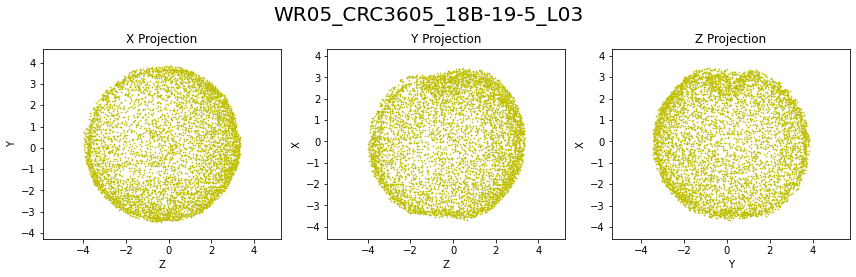

In [5]:
oil_dst = oil_src + bname + '/' + lname + '/'
filename = oil_dst + bname + '_' + lname + '_glands.csv'
glands = np.loadtxt(filename, delimiter=',', dtype=float)
glands = np.matmul(glands, np.transpose(vh))
glands = (glands - np.mean(glands, axis = 0))/(.5*np.std(glands[:,0]))

dst = oil_src + bname + '/'
vitaminC.plot_3Dprojections(glands, title=bname+'_'+lname, writefig=savefig, dst=dst)

# Compute the general conic parameters

Here we follow the algorithm laid out by [Li and Griffiths (2004)](https://doi.org/10.1109/GMAP.2004.1290055). 


A general quadratic surface is defined by the equation

$$\eqalignno{ & ax^{2}+by^{2}+cz^{2}+2fxy+2gyz+2hzy\ \ \ \ \ \ \ \ \ &\hbox{(1)}\cr &+2px+2qy+2rz+d=0.}$$

Let $$\rho = \frac{4J-I}{a^2 + b^2 + c^2},$$

$$\eqalignno{ &I = a+b+c &\hbox{(2)}\cr &J =ab+bc+ac-f^{2}-g^{2}-h^{2}&\hbox {(3)}\cr & K=\left[\matrix{ a & h & g \cr h & b & f \cr g & f & c }\right] &\hbox{(4)}}.$$

These values are invariant under rotation and translation and equation (1) represents an ellipsoid if $J > 0$ and $IK>0$.

With our observations $\{(x_i,y_i,z_i)\}_i$, we would ideally want a vector of parameters $(a,b,c,f,g,h,p,q,r,d)$ such that

$$
\begin{pmatrix}
x_1^2 & y_1^2 & z_1^2 & 2x_1y_1 & 2y_1z_1 & 2x_1z_1 & x_1 & y_1 & z_1 & 1\\
x_2^2 & y_2^2 & z_2^2 & 2x_2y_2 & 2y_2z_2 & 2x_2z_2 & x_2 & y_2 & z_2 & 1\\
\vdots& \vdots& \vdots& \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
x_n^2 & y_n^2 & z_n^2 & 2x_ny_n & 2y_nz_n & 2x_nz_n & x_n & y_n & z_n & 1
\end{pmatrix}
\begin{pmatrix}
a \\ b \\ \vdots \\ d
\end{pmatrix}
=
\begin{pmatrix}
0 \\ 0 \\ \vdots \\ 0
\end{pmatrix}
$$
or
$$
\mathbf{D}\mathbf{v} = 0
$$

The solution to the system above can be obtained via Lagrange multipliers

$$\min_{\mathbf{v}\in\mathbb{R}^{10}}\left\|\mathbf{D}\mathbf{v}\right\|^2, \quad \mathrm{s.t.}\; kJ - I^2 = 1$$

If $k=4$, the resulting vector $\mathbf{v}$ is guaranteed to be an ellipsoid. 

- Experimental results suggest that the optimization problem also yields ellipsoids for higher $k$'s if there are enough sample points.

---

- This whole procedure yields a 10-dimensional vector $(a,b,c,f,g,h,p,q,r,1)$, which is then translated to geometric parameters as shown in [Panou et al. (2020)](https://doi.org/10.1515/jogs-2020-0105)

In [6]:
bbox = (np.max(glands, axis=0) - np.min(glands, axis=0))*.5
guess = np.argsort(np.argsort(bbox))
print(bbox)
print(guess[rotateby])
bbox[rotateby]

[3.54225205 3.64376594 3.66129204]
[2 1 0]


array([3.66129204, 3.64376594, 3.54225205])

In [7]:
datapoints = glands.T

filename = oil_src + bname + '/' + lname + '/' + bname + '_' + lname + '_ell_v.csv'
if os.path.isfile(filename):
    ell_v_params = np.loadtxt(filename, delimiter=',')
    print('Loaded', filename)
else:
    ell_v_params, flag = vitaminC.ell_algebraic_fit2(datapoints, k=4)
    print(np.around(ell_v_params,3), '\n', flag, 'ellipsoid\n')
    np.savetxt(filename, ell_v_params, delimiter=',')

filename = oil_src + bname + '/' + lname + '/' + bname + '_' + lname + '_ell_m.csv'
if os.path.isfile(filename):
    foo = np.loadtxt(filename, delimiter=',')
    ell_params = {'center': foo[0],
                  'axes': foo[1],
                  'rotation': foo[2:5],
                  'theta': foo[5]}
    print('Loaded', filename)
else:
    ell_params = vitaminC.get_ell_params_from_vector(ell_v_params, guess[rotateby])
    np.savetxt(filename, np.vstack(tuple(ell_params.values())), delimiter=',')
    
ell_params

[ 0.085  0.079  0.079  0.002 -0.003 -0.001  0.011 -0.013  0.021 -1.   ] 
 True ellipsoid



{'center': array([-0.07053917,  0.08326707, -0.13670603]),
 'axes': array([3.57717662, 3.57295421, 3.41809634]),
 'rotation': array([[-0.20287374,  0.9710181 , -0.12635698],
        [ 0.20009144,  0.16742639,  0.96536616],
        [ 0.95854351,  0.17056449, -0.22825883]]),
 'theta': array([0.64173339, 1.28184603, 0.77849371])}

## Make sense of all the polynomial parameters 

In [ ]:
footpoints = 'geocentric'

_, xyz = vitaminC.get_footpoints(datapoints, ell_params, footpoints)
valN = vitaminC.geoid_heights(datapoints, xyz)
for i in range(len(nameN)):
    print(nameN[i], ':\t{:.4f}'.format(valN[i]))
rho = vitaminC.ell_rho(ell_params['axes'])
print(rho)

eglands = xyz - ell_params['center'].reshape(-1,1)
eglands = eglands[rotateby]
cglands = datapoints - ell_params['center'].reshape(-1,1)
cglands = cglands[rotateby]

eglands_params = {'center': np.zeros(len(eglands)),
                  'axes': ell_params['axes'],
                  'rotation': np.identity(len(eglands))}
geodetic, _ = vitaminC.get_footpoints(eglands, eglands_params, footpoints)

filename = oil_dst + bname + '_' + lname + '_' + footpoints + '.csv'
np.savetxt(filename, geodetic.T, delimiter=',')
print('Saved', filename)

In [ ]:
domain_lon = [-np.pi, np.pi]
domain_lat = [-.5*np.pi, 0.5*np.pi]
lonN = 25
latN = 25

longitude = np.linspace(*domain_lon, lonN)
latitude = np.linspace(*domain_lat, latN)

shape_lon, shape_lat = np.meshgrid(longitude, latitude)
lonlat = np.vstack((np.ravel(shape_lon), np.ravel(shape_lat)))

shape_x = vitaminC.ellipsoid(shape_lon, shape_lat, *ell_params['axes'])
ecoords = vitaminC.ellipsoid(*(lonlat), *ell_params['axes'])

In [ ]:
sphere = vitaminC.ellipsoid(*geodetic[:2],1,1,1)
shape_x = vitaminC.ellipsoid(shape_lon, shape_lat, 1,1,1)

In [ ]:
xbar = np.mean(sphere, axis=1)
Rbar = np.linalg.norm(xbar)
xbar0 = xbar/Rbar

print(xbar, Rbar, xbar0, sep='\n')

In [ ]:
dispT = np.zeros((len(sphere), len(sphere)))
for i in range(sphere.shape[1]):
    foo = np.outer(sphere[:,i], sphere[:, i])
    dispT += foo
dispT /= sphere.shape[1]

In [ ]:
eigvalT, eigvecT = np.linalg.eig(dispT)
print(eigvalT)
print(eigvecT)

In [ ]:
title = bname + '_' + lname + ' - ' + footpoints.title() + ' projection'
markersize = 2
sidestep = np.min(bbox)
#sidestep = 0
alpha = .5
fs = 20

filename = oil_dst + '_'.join(np.array(title.split(' '))[[0,2]])

vitaminC.plot_ell_comparison(cglands, eglands, ecoords, title, sidestep, savefig=savefig, filename=filename)

In [ ]:
title = footpoints.title() + " projection - Rho value: {:.3f} - Lambert's cylindrical".format(rho)
filename = oil_dst + bname + '_' + lname + '_' + footpoints + '_lcyl'
vitaminC.plot_lambert_cylindrical(geodetic, latitude, title, savefig=savefig, filename=filename)

In [ ]:
title = footpoints.title() + " projection - Rho value: {:.3f} - Lambert's azimuthal".format(rho)
filename = oil_dst + bname + '_' + lname + '_' + footpoints + '_lazi'

vitaminC.plot_lambert_azimuthal(geodetic, latitude, title, savefig=savefig, filename = filename)

In [ ]:
footpoints = 'geodetic'

geodetic, xyz = vitaminC.get_footpoints(datapoints, ell_params, footpoints)
valN = vitaminC.geoid_heights(datapoints, xyz)
for i in range(len(nameN)):
    print(nameN[i], ':\t{:.4f}'.format(valN[i]))
rho = vitaminC.ell_rho(ell_params['axes'])
print(rho)

filename = oil_dst + bname + '_' + lname + '_' + footpoints + '.csv'
np.savetxt(filename, geodetic.T, delimiter=',')

eglands = xyz - ell_params['center'].reshape(-1,1)
eglands = eglands[rotateby]
cglands = datapoints - ell_params['center'].reshape(-1,1)
cglands = cglands[rotateby]

In [ ]:
title = bname + '_' + lname + ' - ' + footpoints.title() + ' projection'
markersize = 2
sidestep = np.min(bbox)
#sidestep = 0
alpha = .5
fs = 20

filename = oil_dst + '_'.join(np.array(title.split(' '))[[0,2]])

vitaminC.plot_ell_comparison(cglands, eglands, ecoords, title, sidestep, savefig=savefig, filename=filename)

In [ ]:
title = footpoints.title() + " projection - Rho value: {:.3f} - Lambert's cylindrical".format(rho)
filename = oil_dst + bname + '_' + lname + '_' + footpoints + '_lcyl'
vitaminC.plot_lambert_cylindrical(geodetic, latitude, title, savefig=savefig, filename=filename)

In [ ]:
title = footpoints.title() + " projection - Rho value: {:.3f} - Lambert's azimuthal".format(rho)
filename = oil_dst + bname + '_' + lname + '_' + footpoints + '_lazi'

vitaminC.plot_lambert_azimuthal(geodetic, latitude, title, savefig=savefig, filename = filename)

In [ ]:
reload(vitaminC)
#lats = axes[0]*np.sin(theta[len(theta)//2:-1])
lats = np.linspace(0, axes[0], thetaN//2,endpoint=False)
areas = np.zeros(len(lats)+1)
for i in range(len(lats)):
    areas[i] = vitaminC.ellipsArea(*axes, lats[i], False)
total_area = areas[0]
areas[0] *= .5
sections = np.abs(np.ediff1d(areas))
lat_area = np.hstack((np.flip(sections), sections))

In [ ]:
def vonmises_kde(data, kappa, n_bins=100):
    bins = np.linspace(-np.pi, np.pi, n_bins)
    x = np.linspace(-np.pi, np.pi, n_bins)
    # integrate vonmises kernels
    kde = np.exp(kappa*np.cos(x[:, None]-data[None, :])).sum(1)/(2*np.pi*i0(kappa))
    kde /= np.trapz(kde, x=bins)
    return bins, kde

In [ ]:
i = 49

print(theta[i])
print(theta[i-1])

slice_mask = (latitud <= theta[i]) & (latitud > theta[i-1])
lon = azimuth[slice_mask] - np.pi
lat = latitud[slice_mask]

print('lon: ',len(lon))
# plot data histogram
fig, ax = plt.subplots(2, 1, figsize=(14,12))

bw = 0.1
x, kde = vonmises_kde(lon, 1./bw, lambdaN)

rng = np.random.default_rng()
N = len(lon)
u = rng.uniform(0,1,size=N)
idxs = (u*len(lon)).astype(int)
lon_sample = (rng.vonmises(lon[idxs], 1./bw))
bins = np.linspace(-np.pi, np.pi, len(lon)//8)

ax[0].plot(x, kde, lw=3, c='black', label='kde');
ax[0].scatter(lon, np.zeros_like(lon)-0.01, c='m', s=75, alpha=.4, marker='o');
ax[0].scatter(lon_sample, np.zeros_like(lon)-0.03, c='forestgreen', s=75, alpha=.4, marker='o');
ax[0].hist(lon, bins, density=True, alpha=0.5, color='m', label='original')
ax[0].hist(lon_sample, bins, density=True, alpha=0.5, color='forestgreen', label='sampled');
ax[0].set_ylabel('Density', fontsize=fs); ax[0].set_xlabel('Longitude', fontsize=fs)
ax[0].set_title('Von Mises KDE', fontsize=fs)
ax[0].legend()

x = np.linspace(theta[i-1], theta[i], 100)

gland_kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(lat.reshape(-1,1))
lat_sample = gland_kde.sample(N)
gland_distr = np.exp(gland_kde.score_samples(x.reshape(-1,1)))

ax[1].plot(gland_distr, x, lw=3);
ax[1].scatter(np.zeros_like(lat)+2, lat, c='m', s=75, alpha=.4, marker='o');
ax[1].scatter(np.zeros_like(lat), lat_sample, c='forestgreen', s=75, alpha=.4, marker='o');
ax[1].set_xlabel('Density', fontsize=fs); ax[1].set_ylabel('Latitude', fontsize=fs)
ax[1].set_title('Gaussian-Euclidean KDE', fontsize=fs);

In [ ]:
bw = 0.1
rng = np.random.default_rng()
vm_kde = np.zeros((thetaN-1, lambdaN))

lats_sample = []
lons_sample = []

for i in range(1,len(theta)):
    
    slice_mask = (latitud <= theta[i]) & (latitud > theta[i-1])
    lon = azimuth[slice_mask] - np.pi
    lat = latitud[slice_mask]
    _, vm_kde[i-1] = vonmises_kde(lon, 1./bw, lambdaN)

    N = len(lon)
    u = rng.uniform(0,1,size=N)
    idxs = (u*len(lon)).astype(int)
    lon_sample = (rng.vonmises(lon[idxs], 1./bw))
    x = np.linspace(theta[i-1], theta[i], 100)

    gland_kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(lat.reshape(-1,1))
    lat_sample = gland_kde.sample(N).squeeze()
    
    lons_sample = np.hstack((lons_sample, lon_sample))
    lats_sample = np.hstack((lats_sample, lat_sample))

In [ ]:
lat_dig = np.digitize(latitud, bins=theta)
lat_area_norm = lat_area/np.max(lat_area)

weight = 2. - lat_area_norm[lat_dig-1]
delta_theta = (theta[1]-theta[0])*.5
midtheta = theta[:-1] + delta_theta

gland_kde_params = {'bandwidth':0.1,
                    'kernel':'gaussian'}
gland_kde = KernelDensity(**gland_kde_params).fit(latitud.reshape(-1,1))
gland_kde_w = KernelDensity(**gland_kde_params).fit(latitud.reshape(-1,1), sample_weight=weight)
gland_distr = np.exp(gland_kde.score_samples(midtheta.reshape(-1,1)))
gland_distr_w = np.exp(gland_kde_w.score_samples(midtheta.reshape(-1,1)))

In [ ]:
N = len(glands)//10
rng = np.random.RandomState(42)
lats_sample = gland_kde_w.sample(N, rng).squeeze()
lats_sample[lats_sample > np.pi*.5] = np.pi - lats_sample[lats_sample > np.pi*.5]
lats_sample[lats_sample < -np.pi*.5] = -np.pi-lats_sample[lats_sample < -np.pi*.5]

sample_dig = np.digitize(lats_sample, bins=theta)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,10), sharey=True, sharex=True)

ax[0].imshow(np.multiply(vm_kde, gland_distr_w.reshape(-1,1)), cmap='plasma', origin='lower');
ax[0].set_title('Weighted', fontsize=fs)
ax[1].imshow(np.multiply(vm_kde, gland_distr.reshape(-1,1)), cmap='plasma', origin='lower');
ax[1].set_title('Unweighted', fontsize=fs)

fig.tight_layout();

In [ ]:
lons_sample = np.zeros_like(lats_sample)
rng = np.random.default_rng()

for i in range(1,thetaN):
    lat_mask = sample_dig == i
    N = np.sum(lat_mask)
    u = rng.uniform(0,1,size=N)
    slice_mask = (latitud <= theta[i]) & (latitud > theta[i-1])
    lon = azimuth[slice_mask] - np.pi
    idxs = (u*len(lon)).astype(int)
    
    lons_sample[lat_mask] = rng.vonmises(lon[idxs], 1./bw)

In [ ]:
sample = ellipsoid_fun(lons_sample, lats_sample, *axes)
sample_map, _ = vitaminC.cyl_overlap(lons_sample, lats_sample)

fig, ax = plt.subplots(2,1,figsize=(14,6), sharey=True, sharex=True)

ax[0].scatter(skin_map[:,0], np.sin(skin_map[:,1]), alpha=0.2)
ax[0].set_ylabel('Latitude', fontsize=fs);
ax[0].set_title('Original', fontsize=fs)

ax[1].scatter(sample_map[:,0], np.sin(sample_map[:,1]), alpha=0.2)
ax[1].set_xlabel('Longitude', fontsize=fs); ax[1].set_ylabel('Latitude', fontsize=fs);
ax[1].set_title('Sampled', fontsize=fs);

fig.tight_layout()

In [ ]:
vitaminC.plot_3Dprojections(skin.T, title='original')
vitaminC.plot_3Dprojections(sample.T, title='reworked and reconstructed')

In [ ]:
shape_lon, shape_lat = np.meshgrid(llambda, midtheta)
latlon = np.vstack((np.ravel(shape_lon), np.ravel(shape_lat)))

edensity = np.ravel(vm_kde)
edensity = np.ravel(np.multiply(vm_kde, gland_distr_w.reshape(-1,1)))

In [ ]:
kde_params = {'kernel': 'gaussian',
              'bandwidth': 0.35,
              'metric': 'euclidean',
              'algorithm': 'kd_tree'
              #'metric_params' : {'p':3}
              }
kde = KernelDensity(**kde_params).fit(skin.T)
#sdensity = np.exp(kde.score_samples(skin))
edensity = np.exp(kde.score_samples(ellipsoid.T))

In [ ]:
lat_avg = np.empty((len(midtheta), 4))

for idx in range(len(lat_avg)):
    foo = edensity[idx*lambdaN:(idx+1)*lambdaN]
    lat_avg[idx,:] = np.min(foo), np.max(foo), np.mean(foo), np.std(foo)

In [ ]:
imwidth = 10
lambertx = np.linspace(-30, 390, 15).astype(int)
lamberty = np.hstack(([-0.26,.26], np.linspace(-.5*np.pi, .5*np.pi, 7)))

plt.figure(figsize=(1, 6))
plt.scatter(np.tile(np.arange(imwidth), len(midtheta)), np.sin(np.repeat(midtheta,imwidth)), 
            c = np.repeat(lat_avg[:,2], imwidth), 
            cmap='plasma', marker='s', s=90);
plt.scatter(np.tile(np.arange(imwidth), len(midtheta))+15, np.sin(np.repeat(midtheta,imwidth)), 
            c = np.repeat(lat_avg[:,3], imwidth), 
            cmap='plasma', marker='s', s=90);

plt.xticks([]);
plt.yticks(np.sin(lamberty), np.rint(np.degrees(lamberty)).astype(int));
plt.margins(x=0, y=0)

In [ ]:
plt.figure(figsize=(14,6))
lamberty = np.hstack(([-0.26,.26], np.linspace(-.5*np.pi, .5*np.pi, 7)))
lambertx = np.linspace(0, 360, 9).astype(int)

heatmap, heatmask = vitaminC.cyl_overlap(*latlon)
hm_density = np.tile(edensity, 3)

plt.scatter(heatmap[:,0], np.sin(heatmap[:,1]), alpha=1, c=hm_density[heatmask], cmap='plasma', 
            s=90, marker='s');
plt.margins(x=0, y=0);
plt.axvline(x=2*np.pi, c='gray', ls='-.');
plt.axvline(x=0, c='silver', ls='-.');

In [ ]:
hist, _ = np.histogram(latitud, bins=theta)
avg_glands = hist/lat_area
avg_glands /= np.trapz(avg_glands, x=theta[1:])

In [ ]:
lat_area_norm = lat_area/np.max(lat_area)
2 - lat_area_norm

In [ ]:
lat_dig = np.digitize(latitud, bins=theta)
weight = 2-lat_area_norm[lat_dig-1]

In [ ]:
gland_kde_params = {'bandwidth':0.1,
                    'kernel':'gaussian'}
gland_kde = KernelDensity(**gland_kde_params).fit(latitud.reshape(-1,1))
gland_kde_w = KernelDensity(**gland_kde_params).fit(latitud.reshape(-1,1), sample_weight=weight)
gland_distr = np.exp(gland_kde.score_samples(midtheta.reshape(-1,1)))
gland_distr_w = np.exp(gland_kde_w.score_samples(midtheta.reshape(-1,1)))

In [ ]:
N = 1000
rng = np.random.RandomState()
lats_sample = gland_kde_w.sample(N, rng).squeeze()
lats_sample[lats_sample > np.pi*.5] = np.pi - lats_sample[lats_sample > np.pi*.5]
lats_sample[lats_sample < -np.pi*.5] = -np.pi-lats_sample[lats_sample < -np.pi*.5]

In [ ]:
fig, ax = plt.subplots(1,6, figsize=(15, 6), sharey=True, sharex=True)
ax[0].plot(hist/np.trapz(hist, x=theta[1:]), (theta)[1:], alpha=1, lw=3);
ax[0].fill_betweenx((theta)[1:], hist/np.trapz(hist, x=theta[1:]), alpha=0.3, lw=2);

ax[1].plot(avg_glands, (theta)[1:], alpha=1, lw=3);
ax[1].fill_betweenx((theta)[1:], avg_glands, alpha=0.3, lw=2);

ax[2].plot(gland_distr, (theta), alpha=1, lw=3);
ax[2].fill_betweenx((theta), gland_distr, alpha=0.3);

ax[3].plot(gland_distr_w, (theta), alpha=1, lw=3);
ax[3].fill_betweenx((theta), gland_distr_w, alpha=0.3);

ax[4].plot(hist/np.trapz(hist, x=theta[1:]), (theta)[1:], alpha=1, lw=3, label='hist');
ax[4].plot(avg_glands, (theta)[1:], alpha=1, lw=3, label='avg');
ax[4].plot(gland_distr, (theta), alpha=1, lw=3, label='kde');
ax[4].plot(gland_distr_w, (theta), alpha=1, lw=3, label='kde_w');
ax[4].legend(fontsize=12);

ax[5].scatter(np.zeros_like(latitud)+0.15, latitud, alpha=0.005);
ax[5].scatter(np.zeros_like(lats_sample)+0.5, lats_sample, alpha=0.05);

fig.tight_layout();

In [ ]:
N = len(glands)
rng = np.random.RandomState(4)
sample = kde.sample(N, rng)
_, slatitud, _, sazimuth, _ = vitaminC.cartesian_to_polar(sample)
samp = np.column_stack((axes[0]*np.sin(slatitud),
                        axes[1]*np.cos(slatitud)*np.sin(sazimuth),
                        axes[2]*np.cos(slatitud)*np.cos(sazimuth)))

samp_map, _ = vitaminC.cyl_overlap(sazimuth, slatitud)

In [ ]:
#vitaminC.plot_3Dprojections(sample, title=bname+'_'+lname + ' sampled')
vitaminC.plot_3Dprojections(skin.T, title=bname+'_'+lname + ' approx ellipsoid')
vitaminC.plot_3Dprojections(samp, title=bname+'_'+lname + ' sampled')

In [ ]:
N = len(glands)//10
sample = kde.sample(N, rng)
_, slatitud, _, sazimuth, _ = vitaminC.cartesian_to_polar(sample)
samp = np.column_stack((axes[0]*np.sin(slatitud),
                        axes[1]*np.cos(slatitud)*np.sin(sazimuth),
                        axes[2]*np.cos(slatitud)*np.cos(sazimuth)))
samp_map, _ = vitaminC.cyl_overlap(sazimuth, slatitud)

sample_kde = KernelDensity(bandwidth=0.15).fit(slatitud.reshape(-1,1))
sample_distr = np.exp(sample_kde.score_samples(theta.reshape(-1,1)))

In [ ]:
lambertx = np.linspace(-30, 390, 15).astype(int)
lamberty = np.hstack(([-0.26,.26], np.linspace(-.5*np.pi, .5*np.pi, 7)))

fs = 22

fig = plt.figure(constrained_layout=True, figsize=(21,12))
gs = fig.add_gridspec(3,17)

ax = fig.add_subplot(gs[0,:2])
ax.scatter(eglands[:, 2], eglands[:,1], c='y', s=2)
ax.set_aspect('equal', 'datalim');
ax.set_ylabel('X Projection', fontsize=fs)
ax.set_xticks([])
#ax.set_yticks([])
ax.tick_params(labelsize = int(0.75*fs))
ax = fig.add_subplot(gs[0,2:4])
ax.scatter(skin[:, 2], skin[:,1], c='y', s=2)
ax.set_aspect('equal', 'datalim');
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot(gs[0,4:6])
ax.scatter(samp[:, 2], samp[:,1], c='y', s=2)
ax.set_aspect('equal', 'datalim');
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(gs[1,:2])
ax.scatter(eglands[:, 1], eglands[:,0], c='y', s=2)
ax.set_aspect('equal', 'datalim');
ax.set_ylabel('Y Projection', fontsize=fs)
ax.set_xticks([])
#ax.set_yticks([])
ax.tick_params(labelsize = int(0.75*fs))
ax = fig.add_subplot(gs[1,2:4])
ax.scatter(skin[:, 1], skin[:,0], c='y', s=2)
ax.set_aspect('equal', 'datalim');
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot(gs[1,4:6])
ax.scatter(samp[:, 1], samp[:,0], c='y', s=2)
ax.set_aspect('equal', 'datalim');
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(gs[2,:2])
ax.scatter(eglands[:, 2], eglands[:,0], c='y', s=2)
ax.set_aspect('equal', 'datalim');
ax.set_xlabel('Oil glands', fontsize=fs)
ax.set_ylabel('Z Projection', fontsize=fs)
#ax.set_xticks([])
#ax.set_yticks([])
ax.tick_params(labelsize = int(0.75*fs))
ax = fig.add_subplot(gs[2,2:4])
ax.scatter(skin[:, 2], skin[:,0], c='y', s=2)
ax.set_aspect('equal', 'datalim');
ax.set_xlabel('Apprx\nellipsoid', fontsize=fs)
#ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(labelsize = int(0.75*fs))
ax = fig.add_subplot(gs[2,4:6])
ax.scatter(samp[:, 2], samp[:,0], c='y', s=2)
ax.set_aspect('equal', 'datalim');
ax.set_xlabel('Sampled\nellipsoid', fontsize=fs)
#ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(labelsize = int(0.75*fs))

ax03 = fig.add_subplot(gs[0,7:-1])
ax03.scatter(skin_map[:,0], np.sin(skin_map[:,1]), alpha=0.2);
ax03.axvline(x=2*np.pi, c='k', ls='-.');
ax03.axvline(x=0, c='black', ls='-.');
ax03.tick_params(labelsize = int(0.75*fs))
ax03.set_yticks(np.sin(lamberty))
ax03.set_yticklabels(np.rint(lamberty*180/np.pi).astype(int));
ax03.set_xticks(lambertx*np.pi/180)
ax03.set_xticklabels(lambertx);
ax03.margins(x=0, y=0)
plt.setp(ax03.get_xticklabels(), visible=False)

ax13 = fig.add_subplot(gs[1,7:-1], sharex=ax03, sharey=ax03)
ax13.scatter(heatmap[:,0], np.sin(heatmap[:,1]), alpha=1, c=hm_density[heatmask], cmap='plasma', 
            s=90, marker='s');
ax13.axvline(x=2*np.pi, c='silver', ls='-.');
ax13.axvline(x=0, c='silver', ls='-.');
ax13.set_ylabel('Latitude (deg)', fontsize=fs)
ax13.tick_params(labelsize = int(0.75*fs))
ax13.set_yticks(np.sin(lamberty))
ax13.set_yticklabels(np.rint(lamberty*180/np.pi).astype(int));
ax13.set_xticks(lambertx*np.pi/180)
ax13.set_xticklabels(lambertx);
ax13.margins(x=0, y=0)
plt.setp(ax13.get_xticklabels(), visible=False)

ax23 = fig.add_subplot(gs[2,7:-1], sharex=ax03, sharey=ax03)
ax23.scatter(samp_map[:,0], np.sin(samp_map[:,1]), alpha=0.5)
ax23.set_xlabel('Longitude (deg)', fontsize=fs)
ax23.tick_params(labelsize = int(0.75*fs))
ax23.axvline(x=2*np.pi, c='k', ls='-.');
ax23.axvline(x=0, c='black', ls='-.');
ax23.margins(x=0, y=0)

ax = fig.add_subplot(gs[0, -1])
ax.plot(gland_distr, np.sin(theta), alpha=1, lw=3, color='forestgreen');
ax.fill_betweenx(np.sin(theta), gland_distr, alpha=0.3, color='forestgreen');
ax.set_xticks([]);
ax.set_yticks([]);
ax.margins(x=0.1, y=0)

ax = fig.add_subplot(gs[1, -1])
ax.scatter(np.tile(np.arange(imwidth), len(theta)), np.sin(np.repeat(theta,imwidth)), 
            c = np.repeat(lat_avg[:,2], imwidth), 
            cmap='plasma', marker='s', s=90);
ax.scatter(np.tile(np.arange(imwidth), len(theta))+20, np.sin(np.repeat(theta,imwidth)), 
            c = np.repeat(lat_avg[:,3], imwidth), 
            cmap='plasma', marker='s', s=90);
ax.margins(x=0.3, y=0)
ax.set_xticks([]);
ax.set_yticks([]);
ax = fig.add_subplot(gs[2, -1])
ax.plot(sample_distr, np.sin(theta), alpha=1, lw=3, color='magenta');
ax.fill_betweenx(np.sin(theta), sample_distr, alpha=0.3, color='magenta');
ax.set_xticks([]);
ax.set_yticks([]);
ax.margins(x=0.1, y=0)

fig.suptitle(bname + '_' + lname, fontsize=int(1.5*fs), y=0.93);
#fig.tight_layout()
gs.update(wspace=0.10, hspace=0.1)

filename = oil_src + bname + '/' + bname + '_' + lname + '_ellipsoid_2d_kde.jpg'

#plt.savefig(filename, format='jpg', bbox_inches='tight', dpi=96, pil_kwargs={'optimize':True})

In [ ]:
BW = [0.05, 0.1, 0.2, 0.35, 0.5, 1]
NN = [500, 750, 1000, 1500, 2000]
rng = np.random.RandomState(42)
kernel = 'gaussian'

for bw in BW:
    for N in NN:
        kde_params = {'kernel': kernel,
                      'bandwidth': bw,
                      'metric': 'euclidean',
                      'algorithm': 'kd_tree'
                     }
        kde = KernelDensity(**kde_params).fit(skin)
        sample = kde.sample(N, rng)

        filename = oil_src + bname + '/' + lname + '/' 
                   + bname + '_{:04d}_{}_b{:.3f}_kde.csv'.format(N, kernel, bw)

        np.savetxt(filename, sample, delimiter=',', fmt='%.6f')
        
        norms, slatitud, _, sazimuth, _ = vitaminC.cartesian_to_polar(sample)        
        sample_kde = KernelDensity(bandwidth=0.15).fit(slatitud.reshape(-1,1))
        sample_distr = np.exp(sample_kde.score_samples(theta.reshape(-1,1)))

In [ ]:
latlong = np.column_stack((azimuth, latitud))
latitud_kde = KernelDensity(**kde_params).fit(latlong)

latlong = np.column_stack((azimuth, polar))
polar_kde = KernelDensity(**kde_params).fit(latlong)


for N in [500, 750, 1000, 1500, 2000]:
    #print('{:04d}'.format(N))
    sample = sample_kde(N, latitud_kde)
    filename = oil_src + bname + '/' + lname + '/' + bname + '_{:04d}_kde_sample.csv'.format(N)
    np.savetxt(filename, sample, delimiter=',', fmt='%.6f')

In [ ]:
filename = oil_src + bname + '/' + lname + '/' + bname + '_' + lname + '_3d_sample.csv'
np.savetxt(filename, np.vstack((axes,skin)), delimiter=',', fmt='%.4f')

# References

- **Li, Q**, **Griffiths, J** (2004) Least squares ellipsoid specific fitting. _Geometric Modeling and Processing. Proceedings, 2004_. 335-340. [DOI: 10.1109/GMAP.2004.1290055](https://doi.org/10.1109/GMAP.2004.1290055)

- **Panou, G**, **Korakitis, R**, **Pantazis, G** (2020) Fitting a triaxial ellipsoid to a geoid model. _Journal of Geodetic Science_ **10**(1), 69-82. [DOI: 10.1515/jogs-2020-0105](https://doi.org/10.1515/jogs-2020-0105)